# Brownian dynamics simulator

In [1]:
import numpy as np
from matplotlib.pyplot import *
%matplotlib notebook
from scipy import *
from tqdm.notebook import *

# Rk4 integrator and functions definitions

In [2]:
#########################
#numerical integrator####

def integrate(F,t,y,tstop,dt):
    
    
    def runk4(F,t,y,dt,rx,ry,rz):
        #retorna o incremento apra utilizar na resolucao
        K0=dt*F(t,y,dt,rx,ry,rz)
        K1=dt*F(t+dt/2.,y+K0/2.,dt,rx,ry,rz)
        K2=dt*F(t+dt/2.,y+K1/2.,dt,rx,ry,rz)
        K3=dt*F(t+dt,y+K2,dt,rx,ry,rz)
        return (K0 + 2.*K1 + 2.*K2 + K3)/6.0

    T=[]
    Y=[]
    T.append(t)
    Y.append(y)
    
    pbar = tqdm(total=(tstop-dt))
    while t<tstop:
        pbar.update(dt)
        dt=min(dt,tstop-t)
        
        rx = (np.random.normal(scale=1)) 
        ry = (np.random.normal(scale=1)) 
        rz = (np.random.normal(scale=1)) 
    
        y=y+runk4(F,t,y,dt,rx,ry,rz)
        t=t+dt
        T.append(t)
        Y.append(y)

    return np.array(T),np.array(Y) 

def integrate_euler(F,t,y,tstop,dt):

    def euler(F,t,y,dt):
        #retorna o incremento apra utilizar na resolucao
        K0=dt*F(t,y)
        return K0

    T=[]
    Y=[]
    T.append(t)
    Y.append(y)
    
    pbar = tqdm(total=(tstop-dt))
    while t<tstop:
        pbar.update(dt)
        dt=min(dt,tstop-t)
        y=y+euler(F,t,y,dt)
        t=t+dt
        T.append(t)
        Y.append(y)

    return np.array(T),np.array(Y) 


##################################
#functions for simulating the dynamics

def harmonic_trap_potential(x,y,z,k,theta):
    kx=k[0]
    ky=k[1]
    kz=k[2]
    return 1/2 *((kx*(x*np.cos(theta)-y*np.sin(theta))**2)+
                     (ky*(x*np.sin(theta)+y*np.cos(theta))**2) + 1/2*kz*z**2)

def harmonic_trap(x,y,z,k,theta):

    
    kx=k[0]
    ky=k[1]
    kz=k[2]
    
    Fx = - (kx*(x*np.cos(theta)-y*np.sin(theta))*np.cos(theta)+(ky*(x*np.sin(theta)+y*np.cos(theta))*np.sin(theta)))
    Fy = - (-kx*(x*np.cos(theta)-y*np.sin(theta))*np.sin(theta)+(ky*(x*np.sin(theta)+y*np.cos(theta))*np.cos(theta)))
    Fz = - kz*z
    return Fx,Fy,Fz

def brownian_simulation(t_stop, dt, k, W, gamma, theta = 0, m=1,delta_x=0,delta_v=0):
    print('k',k)
    print('theta',theta)
    print('W',W)
    
    def F(t,y,dt,rx,ry,rz):

        Fi=np.zeros(6) #[x,vx,y,vy,z,vz]
        Fx,Fy,Fz = harmonic_trap(y[0],y[2],y[4],k,theta)
        
        #normalization factor of the noise - Variance of the noise must be equal to 1/dt
        W1 = W/np.sqrt(dt)
        
        Fi[0]=y[1] 
        Fi[1]= -(gamma/m) * y[1] + Fx/m   + W1/m*rx
        
        Fi[2]=y[3]  
        Fi[3]= -(gamma/m) * y[3] + Fy/m  + W1/m*ry
        
        Fi[4]=y[5] 
        Fi[5]= -(gamma/m) * y[5] + Fz/m + W1/m*rz
            
        return Fi

    
    def initial_condition():
        y=np.zeros(6)

        for i in range(0,6,2):

            y[i] = delta_x*(1-2*np.random.rand())
            y[i+1] = delta_v*(1-2*np.random.rand())

        #define initial position
        #y[0]= 100
        
        return y
    
    r0=initial_condition()
    T,Y=integrate(F,0,r0,t_stop,dt)
    return T,Y


def brownian_simulation_inertial(t_stop, dt, k, W, gamma, theta = 0, m=1,delta_x=0,delta_v=0):
    print('k',k)
    print('theta',theta)
    print('W',W)
    def F(t,y):

        Fi=np.zeros(6) #[x,vx,y,vy,z,vz]
        Fx,Fy,Fz = harmonic_trap(y[0],y[2],y[4],k,theta)
        
        W1 = W/np.sqrt(dt)
        
        Fi[0]= (1/gamma) * Fx + W1/gamma*(np.random.normal(scale=1))
        Fi[1]= 0
        
        Fi[2]= (1/gamma) * Fy + W1/gamma*(np.random.normal(scale=1)) 
        Fi[3]= 0
        
        Fi[4]= (1/gamma) * Fz + W1/gamma*(np.random.normal(scale=1))
        Fi[5]= 0
            
        return Fi

    
    def initial_condition():
        y=np.zeros(6)

        for i in range(0,6,2):

            y[i] = delta_x*(1-2*np.random.rand())
            y[i+1] = delta_v*(1-2*np.random.rand())

        #define initial position
        #y[0]= 10
        
        return y
    
    r0=initial_condition()
    T,Y=integrate_euler(F,0,r0,t_stop,dt)
    return T,Y


# Simulation of the Brownian Motion

In [3]:
#[kx,ky,kz] - parameters of the harmonic trap
k_0 = [.2,.1,.5]

#noise parameters
#drag parameter
m=1
gamma_0 = .2
kB = 1
T0 = 1
D = kB * T0 / gamma_0
W_0 = np.sqrt(2*kB*T0*gamma_0)


#xy angle
theta = 0


#simulation time, dt step
t_stop = 10000
dt = 0.1

#simulation Y is a vector with [x,vx,y,vy,z,vz](t)
initial_pos = []
T,Y = brownian_simulation(t_stop,dt, k_0, W_0, gamma = gamma_0, m = m , theta = theta, delta_x=2)

time = T
x_data = Y[:,0]
y_data = Y[:,2] 
z_data = Y[:,4]

k [0.2, 0.1, 0.5]
theta 0
W 0.6324555320336759


  0%|          | 0/9999.9 [00:00<?, ?it/s]

In [4]:
k_0

[0.2, 0.1, 0.5]

# Parameters of the trap

<IPython.core.display.Javascript object>


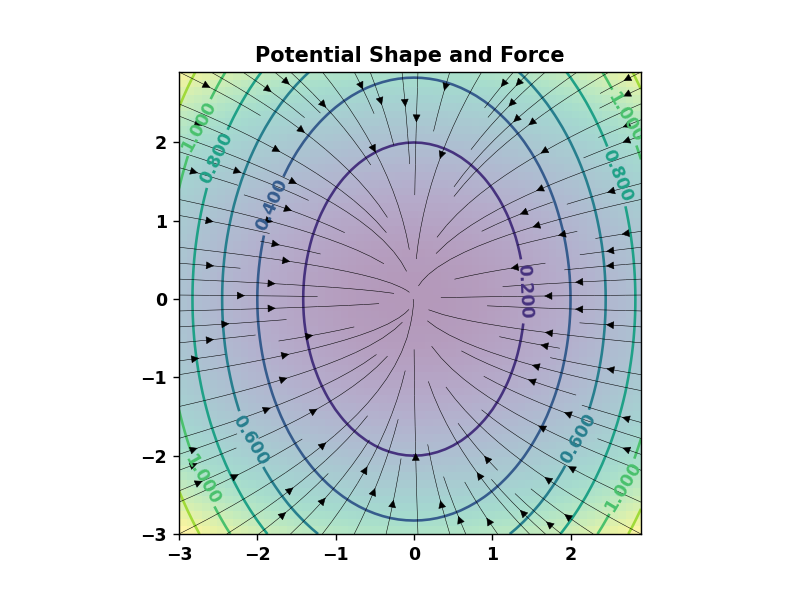

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: scipy.transpose is deprecated and will be removed in SciPy 2.0.0, use numpy.transpose instead
  if __name__ == '__main__':


Text(0.5, 1.0, 'Potential Shape and Force')

In [5]:
x = np.arange(-3,3,0.1) 
y = np.arange(-3,3,0.1)
xx,yy = np.meshgrid(x,y)

Fx,Fy,Vz = harmonic_trap(xx,yy,0,k_0,theta)
V = harmonic_trap_potential(xx,yy,0,k_0,theta)

subplots()
imshow(transpose(V),extent=[np.min(x),np.max(x),np.min(y),np.max(y)],origin='lower',alpha=0.4)
CS = contour(V,extent=[np.min(x),np.max(x),np.min(y),np.max(y)])
clabel(CS, CS.levels, inline=True, fontsize=10)
streamplot(xx,yy,Fx,Fy, density=[1, 1],color='k', linewidth=0.3)
title('Potential Shape and Force')

# Plot the Signals Obtained

<IPython.core.display.Javascript object>


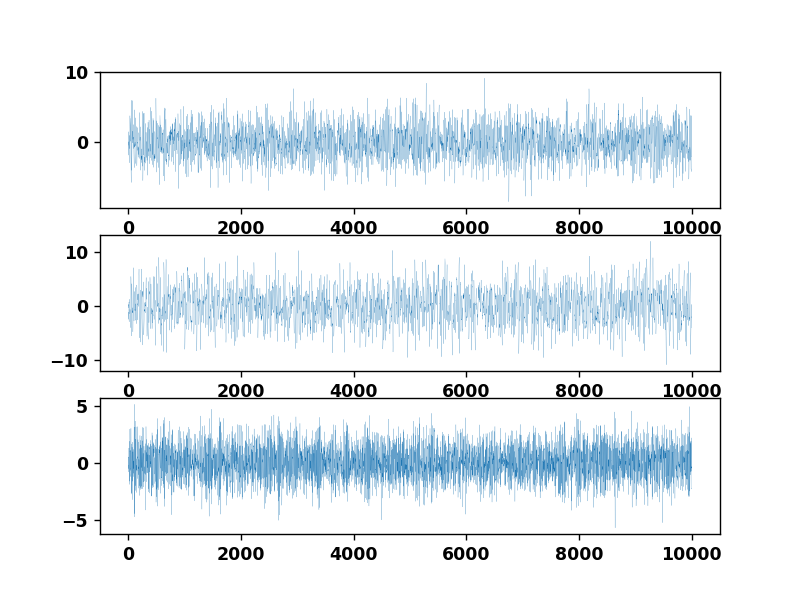

In [6]:
subplots()
title('Signals')
subplot(311)
plot(time, x_data,lw=0.1)
subplot(312)
plot(time, y_data,lw=0.1)
subplot(313)
plot(time, z_data,lw=0.1)

# Plot a 2d histogram (xy) for the position probability

# Stiffness computation using standard deviation

In [7]:
#data retrieved from simulation
plot_step = 5 #a stride to reduce size of data
x_d = Y[:,0][::plot_step]
y_d = Y[:,2][::plot_step]
z_d = Y[:,4][::plot_step]

k_x = (kB*T0)/np.var(x_d)
k_y = (kB*T0)/np.var(y_d)
k_z = (kB*T0)/np.var(z_d)
print(k_x, k_y, k_z)
print(k_0)
print('APE',np.abs(k_x-k_0[0])/k_0[0]*100,
      np.abs(k_y-k_0[1])/k_0[1]*100,np.abs(k_z-k_0[2])/k_0[2]*100)

0.20312840220958867 0.09915799403416563 0.5023262764142119
[0.2, 0.1, 0.5]
APE 1.5642011047943272 0.8420059658343776 0.4652552828423806


# Stiffness computation using Power Spectral Density

<IPython.core.display.Javascript object>


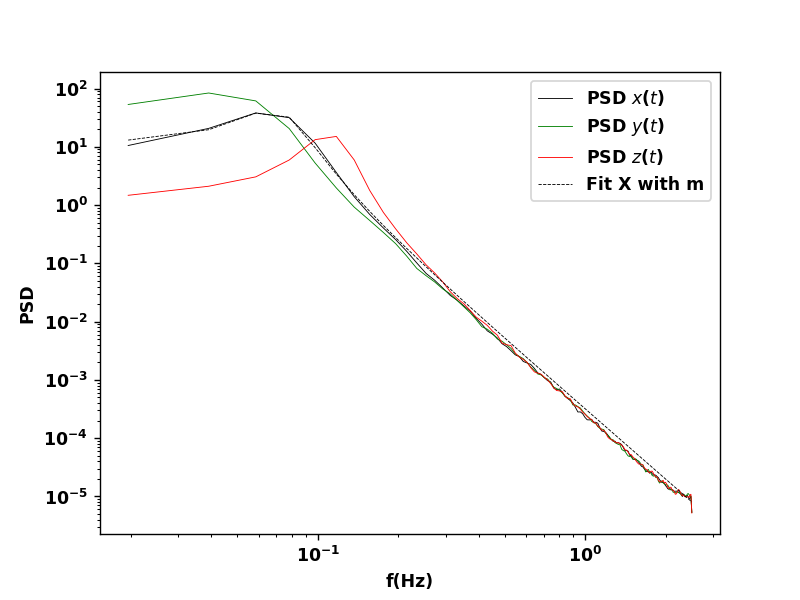

kx 0.20360257165129028 0.2
gamma 0.23775462919101578 0.2
m 0.9851049625778461 1


In [17]:
from scipy import signal
from scipy.optimize import curve_fit

subplots()
step = 2
fs = 1/(step*(T[1]-T[0]))
tstop = 1000000
tinit = 0
f_init = 1
f,psd_x = signal.welch(x_data[tinit:tstop][::step], fs)
psd_x = psd_x / 2
f = f[f_init:]
psd_x = psd_x[f_init:]
f,psd_y =  signal.welch(y_data[tinit:tstop][::step], fs)
psd_y = psd_y / 2
f = f[f_init:]
psd_y = psd_y[f_init:]
f,psd_z = signal.welch(z_data[tinit:tstop][::step], fs)
psd_z = psd_z / 2
f = f[f_init:]
psd_z = psd_z[f_init:]

plot(f,psd_x,lw=0.5,label=r'PSD $x(t)$',color='k')
plot(f,psd_y,lw=0.5,label=r'PSD $y(t)$',color='g')
plot(f,psd_z,lw=0.5,label=r'PSD $z(t)$',color='r')
xscale('log')
yscale('log')
xlabel('f(Hz)')
ylabel('PSD')

def func_m(f, c1,c2,c3):
    return 1/(2*np.pi)**4 * c1 / (f**4+c2*f**2+c3)
    
def func(f, D, f0):
    return 1/(2*np.pi**2) * D /(f**2+f0**2)

x_params_m, pcov_m = curve_fit(func_m, f, psd_x)
#x_params, pcov = curve_fit(func, f, psd_x)

plot(f, func_m(f,x_params_m[0],x_params_m[1],x_params_m[2]),
     lw=0.5,ls='--',color='k',label='Fit X with m')

C1 = x_params_m[0] 
C2 = x_params_m[1]
C3 = x_params_m[2]

A = np.sqrt((C2 + 2*np.sqrt(C3)))
B = 2*kB*T0/C1

gamma_x =(2*np.pi)**2*A**2*B
m_x = 2*np.pi*A*B
k_xx = (2*np.pi)**3*np.sqrt(C3)*A*B

print('kx',k_xx, k_0[0])
print('gamma',gamma_x, gamma_0)
print('m',m_x, m)




legend()

In [9]:
print(C1,C2,C3)

0.09525941872766248 -0.009106548996350744 2.590104287331752e-05


# Stiffness computation using Boltzmann Statistics

<IPython.core.display.Javascript object>


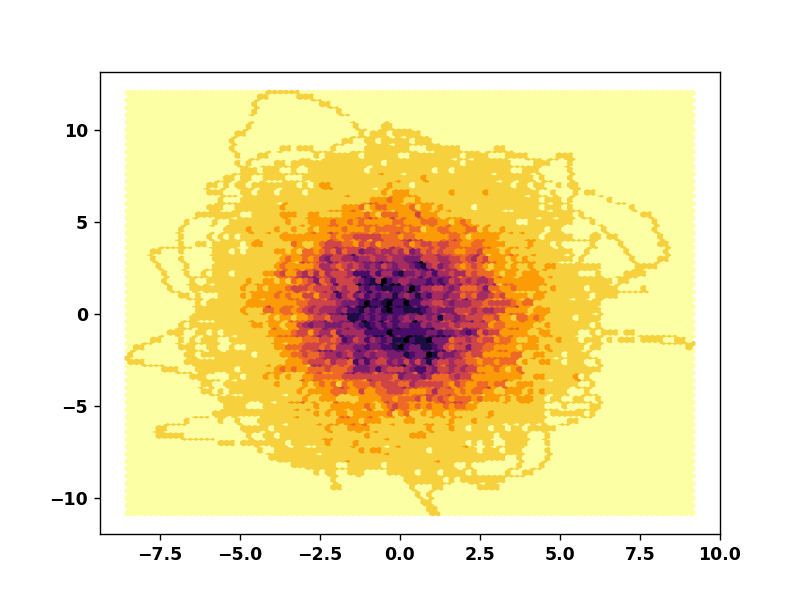

In [10]:
subplots()
hexbin(x_data,y_data,bins=10,cmap = cm.inferno_r)

<IPython.core.display.Javascript object>


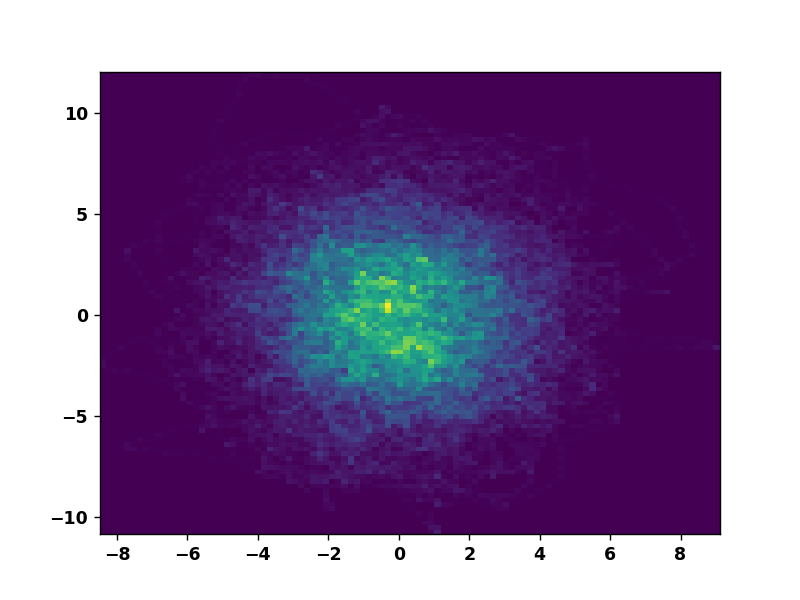

<IPython.core.display.Javascript object>


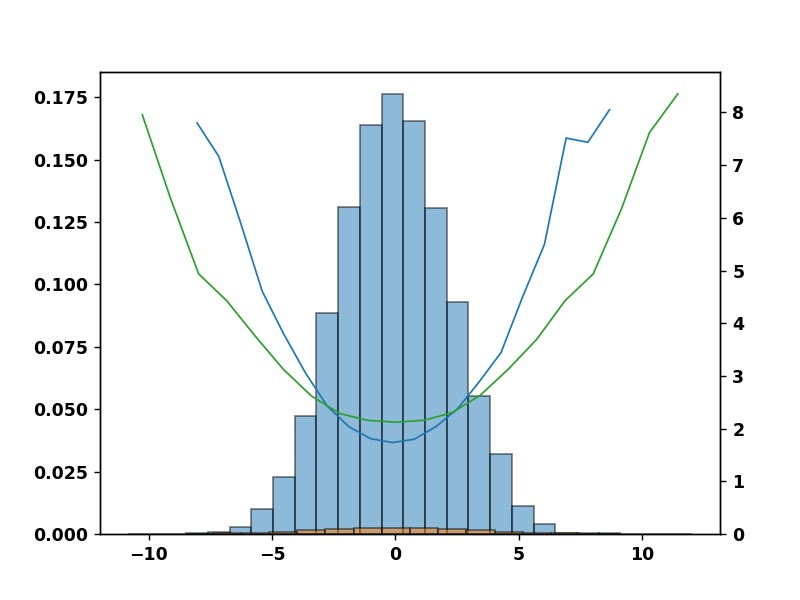

kx 0.26987733108873757 0.20312840220958867
ky 0.15420333971148587 0.09915799403416563


In [11]:
subplots()
h,xedges,yedges,s = hist2d(x_data,y_data,bins=100)
dados = np.column_stack([x_data,y_data])

subplots()

h,edges, s= hist(x_data, bins=20,ec='k',alpha=0.5,density=True)
prob_x = h 
U_x = -kB*T0*np.log(prob_x)
U_x = U_x
xx = np.array((edges+np.roll(edges,-1))/2)[:-1]
ax = gca()
ax1 = twinx(ax)
ax1.plot(xx,U_x,lw=1)

def pot_1d(x,k,x0):
    return 0.5*k*(x-x0)**2

params, pcov = curve_fit(pot_1d,xx,U_x)
print('kx',params[0],k_x)

# subplot(132)
# h,edges, s= hist(y_data, bins=20,ec='k',alpha=0.5,density=True)
# subplot(133)
h,edges, s= hist(y_data, bins=20,ec='k',alpha=0.5,density=True)

prob_y = h 
U_y = -kB*T0*np.log(prob_y)
yy = np.array((edges+np.roll(edges,-1))/2)[:-1]
plot(yy,U_y,lw=1)

params, pcov = curve_fit(pot_1d,yy,U_y)
print('ky',params[0],k_y)
    

# Compare the results